In [1]:
import geopandas as gpd
from shapely.geometry import Point, LineString, MultiPoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopy

/Users/sidd/anaconda3/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Custom Helper Functions using GeoPandas (and other libraries)

In [2]:
def join_reducer(left, right):
    """
    Take two geodataframes, do a spatial join, and return 
    without the index_left and index_right columns
    """
    sjoin = gpd.sjoin(left, right, how='inner')
    for column in ['index_left', 'index_right']:
        try:
            sjoin.drop(column, axis=1, inplace=True)
        except Exception as e:
            # ignore if there are no index columns
            pass
    
    return sjoin

In [3]:
# Function to generate random points and lines on roads

# Source: https://github.com/gboeing/osmnx/issues/639

def sample_roads(geodf, n=100, isLine=False):
  '''
  Sample points and lines(street segments) from a road network
  '''
  m = len(geodf)
  lengths = geodf['LENGTH'].tolist()
  total_length = geodf.sum()['LENGTH']
  lengths_normalized = [l/total_length for l in lengths] 

  indices = np.random.choice(range(m), size=n, p=lengths_normalized)
  # indices = np.random.choice(range(m), size=n)

  if isLine:
    lines = []
    for index in indices:
      line = geodf.iloc[index]['geometry']
      lines.append(line)
  
    # return MultiPoint(lines)
    return gpd.GeoSeries(lines)
  
  points = []
  for index in indices:
      line = geodf.iloc[index]['geometry']
      offset = np.random.rand() * line.length
      point = line.interpolate(offset)
      points.append(point)
      
  # return MultiPoint(points)
  return gpd.GeoSeries(points)

In [4]:
def sample_location(geodf, n, buffer=None):
  '''
  Samples from a shapefile that has 
  ALL entries as point geometries
  '''
  m = len(geodf)
  indices = np.random.choice(range(m), size=n)
  sample = []

  for index in indices:
    point = geodf.iloc[index]['geometry']
    sample.append(point)

  output = gpd.GeoSeries(sample)
  if buffer:
    output.set_crs('EPSG:4326', inplace=True)
    output = output.to_crs(epsg=3763)
    output = output.buffer(buffer)
    output = output.to_crs(epsg=4326)
  return output

In [5]:
def reverse_geocode(geoseries, provider='arcgis'):
  '''
  Function to reverse geocode GeoSeries points
  '''
  return gpd.tools.reverse_geocode(list(geoseries), provider=provider)

In [6]:
def geoseries_to_geodf(geoseries):
  '''
  Converts a simple GeoSeries to a GeoPandas dataframe with a geometry column
  '''
  output_gdf = gpd.GeoDataFrame(geoseries)
  output_gdf.rename(columns={0:'geometry'}).set_geometry('geometry')
  return output_gdf

# Sampling Points and Lines

## Road Network joined w/ County (Boundary)

In [7]:
fl_roads = gpd.read_file("./data/majrds_oct19/majrds_oct19.shp") # LINESTRING geometry
fl_roads = fl_roads.to_crs("EPSG:4326")

In [8]:
fl_roads.head()

,ROADWAY,BEGIN_POST,END_POST,NAME,RD_STATUS,DESCR,ROAD_DIREC,INTERSTATE,TOLLROAD,USROUTE,STROUTE,CNTROAD,LENGTH,FUNCLASS,DESCRIPT,FGDLAQDATE,AUTOID,SHAPE_LEN,geometry
0,02050000,17.626,22.204,E GULF TO LAKE HWY,ACTIVE ON THE SHS,SR 44,3,None,None,None,SR 44,None,7359.917309,14,URBAN: PRINCIPAL ARTERIAL - OTHER,2019-10-07,1,7359.917292,"LINESTRING (-82.32596 28.83246, -82.32537 28.8..."
1,02506000,2.794,3.266,S CARNEGIE DR,ACTIVE OFF THE SHS,OLD FLORAL CITY RD/CARNEGIE DR/EDEN DR,8,None,None,None,None,None,762.484151,18,URBAN: MINOR COLLECTOR (FED AID),2019-10-07,2,762.484100,"LINESTRING (-82.30591 28.81812, -82.30593 28.8..."
2,02010001,0.029,0.066,MAIN ST,ACTIVE ON THE SHS,US 41 REALIGNMENT,4,None,None,US 41,SR 44,None,59.957564,14,URBAN: PRINCIPAL ARTERIAL - OTHER,2019-10-07,3,59.957636,"LINESTRING (-82.34052 28.83598, -82.33990 28.8..."
3,02030000,1.920,4.025,S SUNCOAST BLVD,ACTIVE ON THE SHS,SR55/US 19,1,None,None,US 98,SR 55,None,3396.532606,14,URBAN: PRINCIPAL ARTERIAL - OTHER,2019-10-07,4,3396.532518,"LINESTRING (-82.55263 28.72257, -82.55263 28.7..."
4,02000023,0.000,1.268,E SANDPIPER DR,ACTIVE OFF THE SHS,E SANDPIPER DR,3,None,None,None,None,None,2033.687713,18,URBAN: MINOR COLLECTOR (FED AID),2019-10-07,5,2033.687764,"LINESTRING (-82.29591 28.81046, -82.29580 28.8..."


In [9]:
fl_counties = gpd.read_file("./data/cntbnd_sep15/cntbnd_sep15.shp") # POLYGON geometry
fl_counties = fl_counties.to_crs("EPSG:4326")

In [10]:
fl_counties.head()

,OBJECTID,TIGERNAME,NAME,FGDLCODE,FIPS,DESCRIPT,FGDLAQDATE,COASTAL,AUTOID,geometry
0,7,Broward,BROWARD,C06,011,BROWARD,2015-09-24,Y,7,"MULTIPOLYGON (((-80.08151 26.32086, -80.08142 ..."
1,8,Palm Beach,PALMBEACH,C50,099,PALMBEACH,2015-09-24,Y,8,"MULTIPOLYGON (((-80.08004 26.97052, -80.08003 ..."
2,1,Hernando,HERNANDO,C27,053,HERNANDO,2015-09-24,Y,1,"MULTIPOLYGON (((-82.26305 28.66764, -82.26474 ..."
3,2,Wakulla,WAKULLA,C65,129,WAKULLA,2015-09-24,Y,2,"MULTIPOLYGON (((-84.07776 30.27360, -84.07554 ..."
4,9,Gilchrist,GILCHRIST,C21,041,GILCHRIST,2015-09-24,N,9,"POLYGON ((-82.65856 29.83015, -82.65855 29.830..."


In [11]:
fl_hil = fl_counties[fl_counties['TIGERNAME'] == 'Hillsborough'] 

In [12]:
fl_roads_hil = join_reducer(fl_roads, fl_hil) # road network MUST be left parameter when joining

#### Hillsborough county road network in Florida

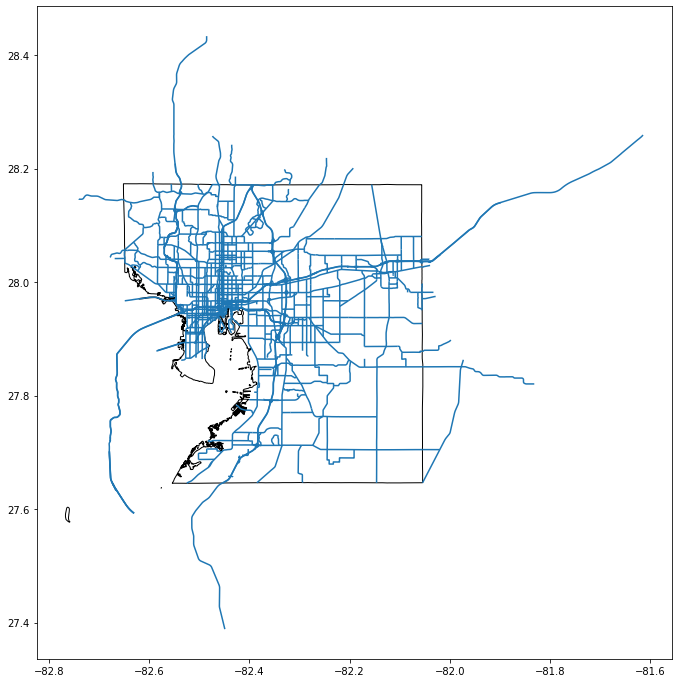

In [13]:
ax = fl_hil.plot(figsize=(14,12), facecolor="none", edgecolor="black")
fl_roads_hil.plot(ax=ax)

In [14]:
sample_road_points = sample_roads(fl_roads_hil, n=5)

In [15]:
reverse_geocode(sample_road_points) # reverse geocoding can only be done on POINT geometry types

,geometry,address
0,POINT (-82.44302 27.98617),"4404 N 15th St, Tampa, Florida 33610, USA"
1,POINT (-82.35750 28.05414),"E Fowler Ave, Tampa, Florida 33637, USA"
2,POINT (-82.24646 28.02247),"I-4 E, Dover, Florida 33527, USA"
3,POINT (-82.13599 28.06692),"N Alexander St, Plant City, Florida 33565, USA"
4,POINT (-82.41035 28.02167),"4363 E Riverhills Dr, Tampa, Florida 33617, USA"


#### 5 randomly sampled points from Hillsborough county road network in Florida

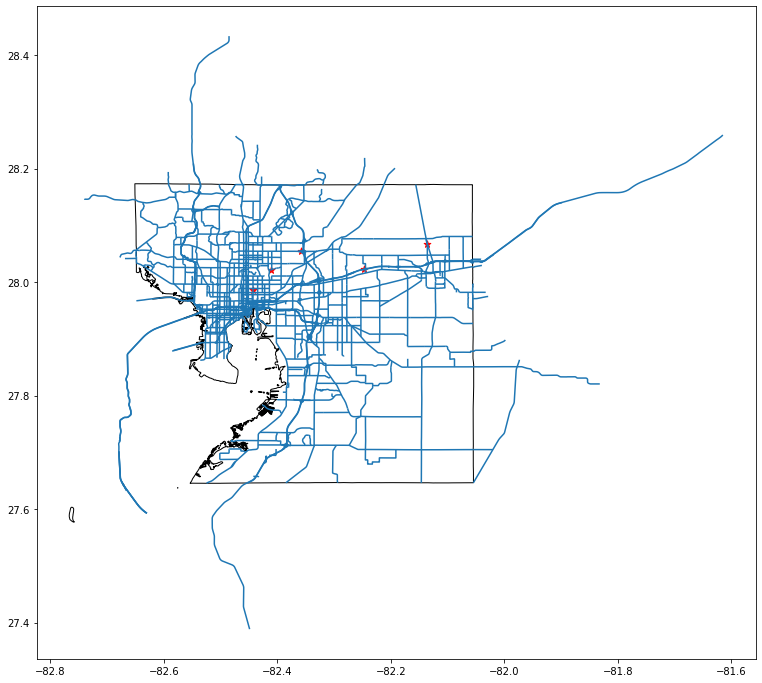

In [16]:
ax = fl_hil.plot(figsize=(14,12), facecolor="none", edgecolor="black")
fl_roads_hil.plot(ax=ax)
sample_road_points.plot(marker='*', color='red', markersize=50, ax=ax)

In [17]:
sample_road_lines = sample_roads(fl_roads_hil, n=5, isLine=True)
sample_road_lines

0    LINESTRING (-82.67773 27.72753, -82.67776 27.7...
1    LINESTRING (-82.12148 27.99331, -82.12148 27.9...
2    LINESTRING (-82.14544 27.85036, -82.13797 27.8...
3    LINESTRING (-82.48869 27.86466, -82.48926 27.8...
4    LINESTRING (-82.45300 27.64629, -82.44535 27.6...
dtype: geometry

#### 5 Randomly sampled lines (road segments) from Hillsborough county road network in Florida

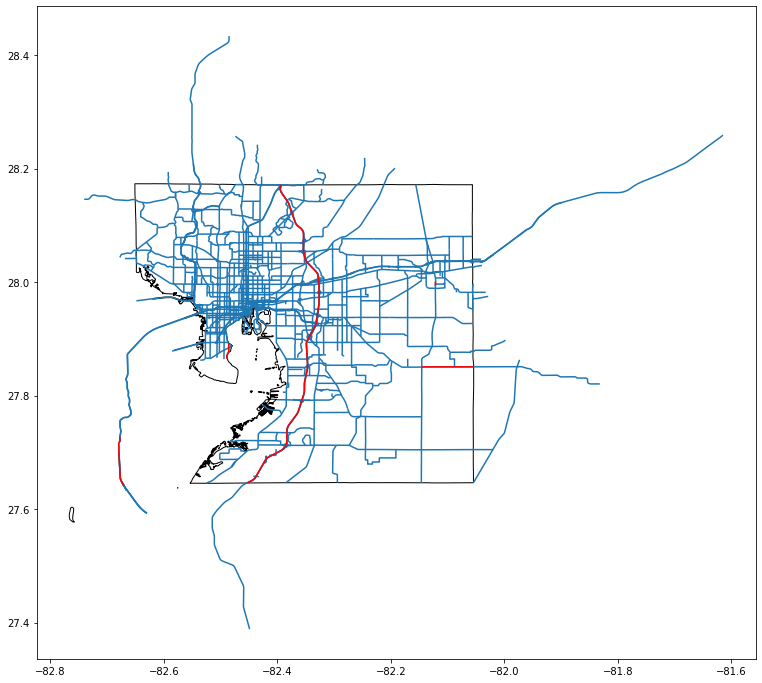

In [18]:
ax = fl_hil.plot(figsize=(14,12), facecolor="none", edgecolor="black")
fl_roads_hil.plot(ax=ax)
sample_road_lines.plot(color='red', ax=ax)

## Road Network joined w/ County joined w/ Civic Centers

In [19]:
fl_civic = gpd.read_file("./data/gc_civiccenter_jan19/gc_civiccenter_jan19.shp")
fl_civic = fl_civic.to_crs("EPSG:4326")

In [20]:
fl_civic.head()

,PARCELID,NAME,ADDRESS,CITY,ZIPCODE,COUNTY,TYPE,OWNER,OPERATING,OP_CLASS,...,MGRS,GOOGLEMAP,GCID,ACRES,DESCRIPT,FLAG,UPDATE_DAY,FGDLAQDATE,AUTOID,geometry
0,17 30 20 00000 210 0100,DERBY LANE,10490 GANDY BLVD,ST PETERSBURG,33702,PINELLAS,GREYHOUND AND/OR HORSE TRACK,ST PETERSBURG KENNEL CLUB INC,PRIVATE,PRIVATE,...,17RLL3975383208,https://www.google.com/maps/place/17RLL3975383208,1452,93.835,DERBY LANE,V,2018-11-15,2018-01-09,1,POINT (-82.62765 27.86407)
1,16 30 10 71010 300 0200,SUNSHINE SPEEDWAY AND DRAGSTRIP,4550 ULMERTON RD,CLEARWATER,33762,PINELLAS,SPEEDWAY,STATE OF FLORIDA,STATE,PUBLIC,...,17RLL3360685583,https://www.google.com/maps/place/17RLL3360685583,1460,50.534,SUNSHINE SPEEDWAY AND DRAGSTRIP,V,2018-11-15,2018-01-09,2,POINT (-82.69040 27.88475)
2,16 30 04 77515 000 2101,CLEARWATER ICE ARENA (SUN BLADES ICE SKATING),13940 ICOT BLVD,CLEARWATER,33760,PINELLAS,ICE SKATING RINKS,ICEPLEX LAND ASSETS LLC,PRIVATE,PRIVATE,...,17RLL3109987171,https://www.google.com/maps/place/17RLL3109987171,1462,4.432,CLEARWATER ICE ARENA (SUN BLADES ICE SKATING),V,2018-11-15,2018-01-09,3,POINT (-82.71609 27.89876)
3,15 29 16 57996 000 0030,CLEARWATER CITY - HARBORVIEW CENTER,300 CLEVELAND ST,CLEARWATER,33755,PINELLAS,RECEPTION HALL,CITY OF CLEARWATER,MUNICIPALITY,PUBLIC,...,17RLL2276594745,https://www.google.com/maps/place/17RLL2276594745,1471,7.825,CLEARWATER CITY - HARBORVIEW CENTER,V,2018-11-15,2018-01-09,4,POINT (-82.80186 27.96602)
4,0141040100010,JOHN J KOUBEK MEMORIAL CENTER AT MIAMI-DADE CO...,2705 SW 3RD ST,MIAMI,33135,MIAMI-DADE,CIVIC CENTERS,STATE OF FLORIDA,STATE,PUBLIC,...,17RNJ7625350412,https://www.google.com/maps/place/17RNJ7625350412,1503,1.696,JOHN J KOUBEK MEMORIAL CENTER AT MIAMI-DADE CO...,V,2018-10-31,2018-01-09,5,POINT (-80.23955 25.76981)


#### All civic centers in Florida

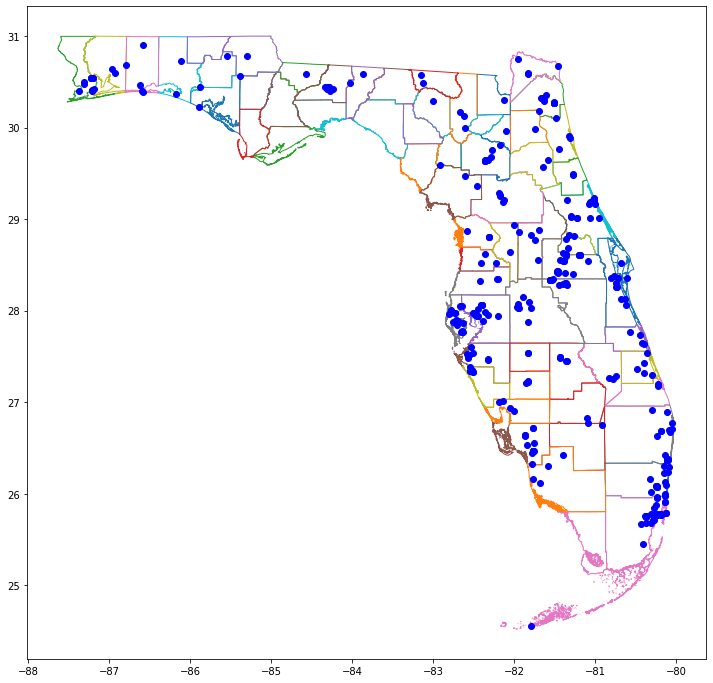

In [21]:
# Plotting multiple layers
fig, ax = plt.subplots(figsize=(14, 12))
fl_counties.plot(ax=ax, facecolor="none", edgecolor='black', column='NAME')
fl_civic.plot(ax=ax, color='blue')

In [22]:
# Reference: https://gis.stackexchange.com/questions/367496/plot-a-circle-with-a-given-radius-around-points-on-map-using-python

In [23]:
fl_civic_hil = join_reducer(fl_civic, fl_hil)

#### Civic centers in Hillsborough county

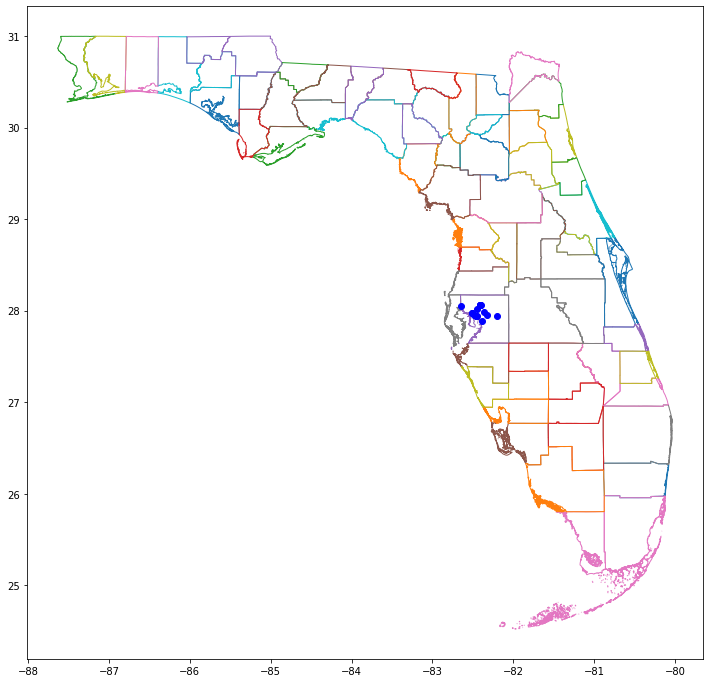

In [24]:
fig, ax = plt.subplots(figsize=(14, 12))
fl_counties.plot(ax=ax, facecolor="none", edgecolor='black', column='NAME')
fl_civic_hil.plot(ax=ax, color='blue')

#### Civic centers plotted on Hillsborough county road network

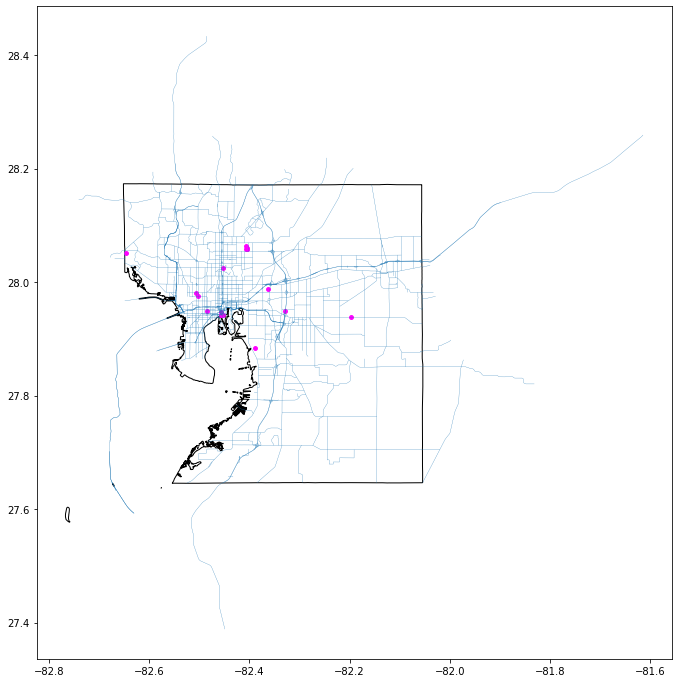

In [25]:
ax = fl_hil.plot(figsize=(14,12), facecolor="none", edgecolor="black")
fl_civic_hil.plot(marker='o', color='magenta', markersize=15, ax=ax)
fl_roads_hil.plot(ax=ax, lw=0.25)

In [26]:
sample_civic_region = sample_location(fl_civic_hil, n=2, buffer=8046.72) # buffer in meters (1 mi = 1609.34 m)

#### Random sampling of 2 civic centers w/ a 5 mi radius on HIL county road nework

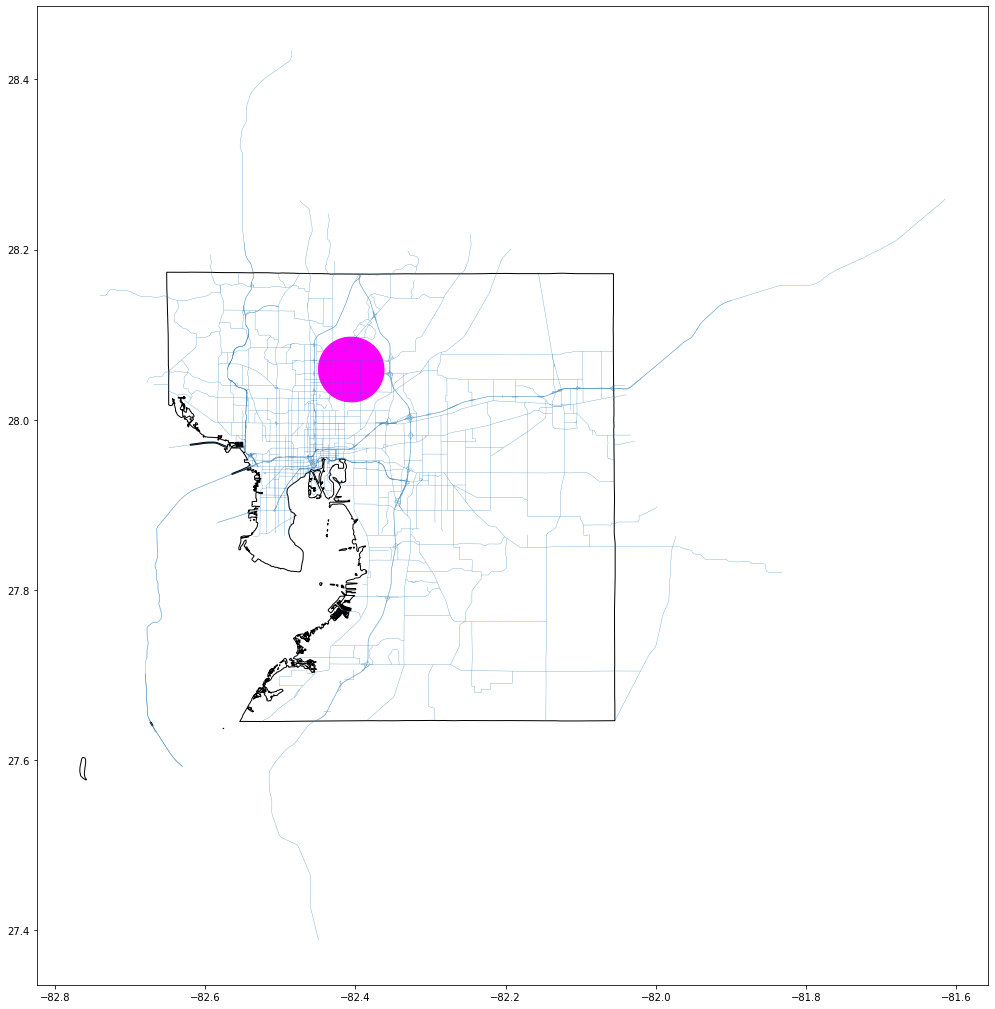

In [27]:
ax = fl_hil.plot(figsize=(20,18), facecolor="none", edgecolor="black")
fl_roads_hil.plot(ax=ax, lw=0.25)
sample_civic_region.plot(marker='o', color='magenta', ax=ax)

In [28]:
sample_civic_df = gpd.GeoDataFrame(sample_civic_region)
sample_civic_df = sample_civic_df.rename(columns={0:'geometry'}).set_geometry('geometry')

In [29]:
fl_roads_hil_sample_civic = join_reducer(fl_roads_hil, sample_civic_df)

#### UNION of HIL road network and sampled civic center regions

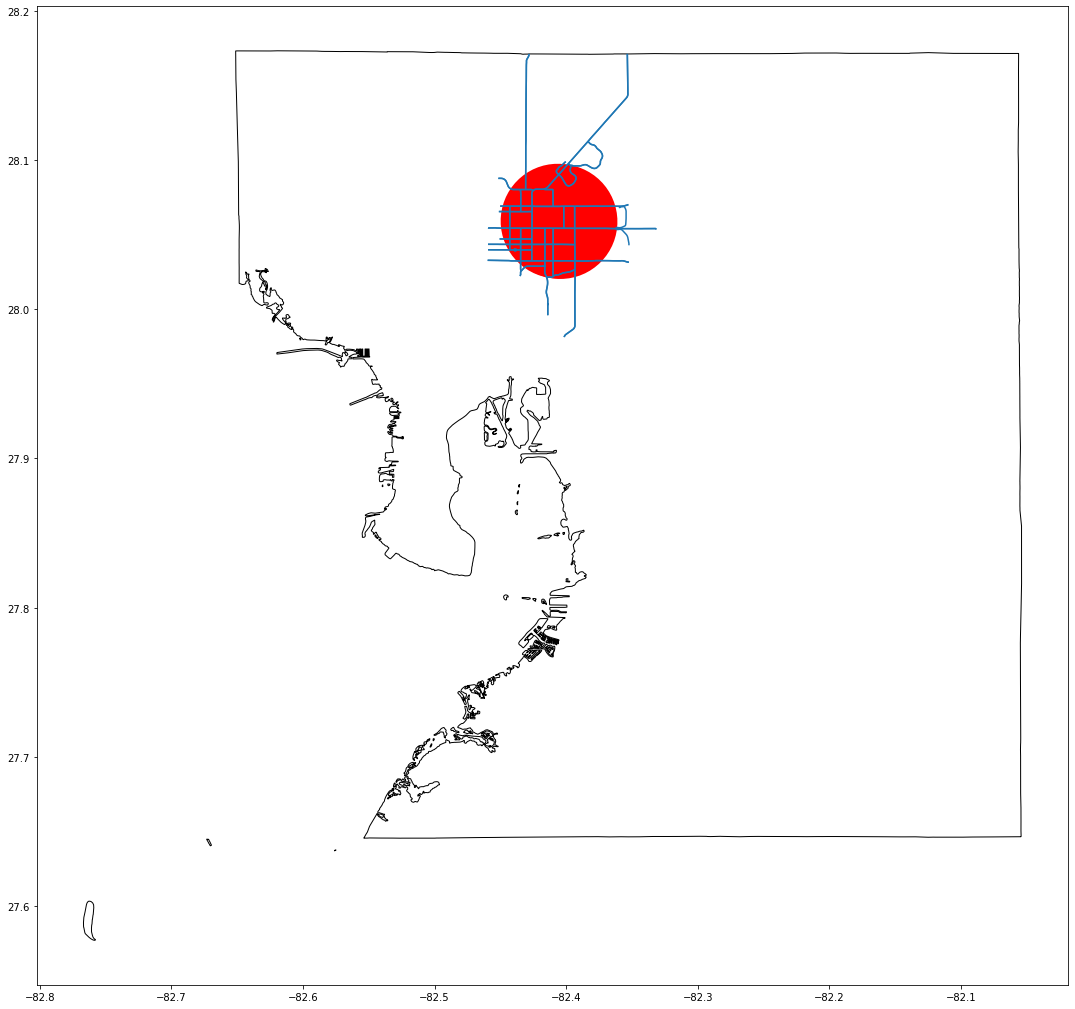

In [30]:
ax = fl_hil.plot(figsize=(20,18), facecolor="none", edgecolor="black")
fl_roads_hil_sample_civic.plot(ax=ax)
sample_civic_region.plot(marker='*', color='red', ax=ax)

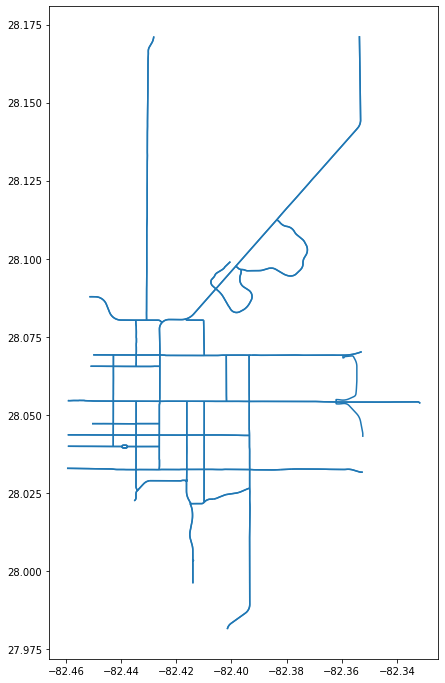

In [31]:
fl_roads_hil_sample_civic.plot(figsize=(14,12))

In [32]:
sample_civic_points = sample_roads(fl_roads_hil_sample_civic, n=5)

#### Sampling 5 points within UNION of HIL road network and sampled civic center regions

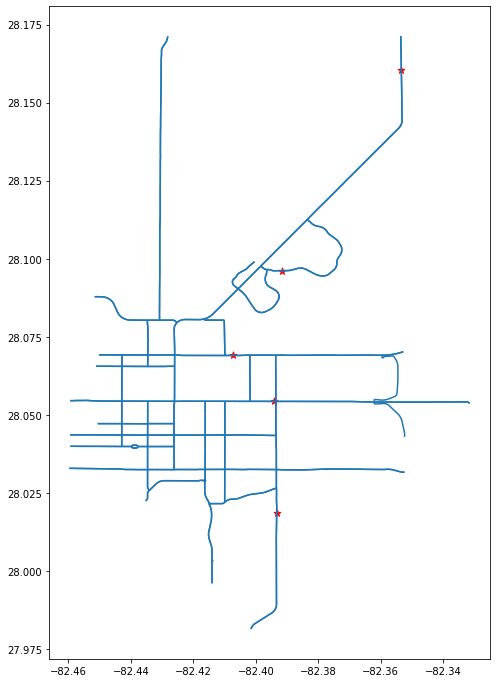

In [33]:
ax = fl_roads_hil_sample_civic.plot(figsize=(14, 12))
sample_civic_points.plot(marker='*', color='red', markersize=50, ax=ax)

In [34]:
lines = fl_roads_hil.geometry.unary_union
intersection = lines.intersection(sample_civic_df.geometry[0])
output = gpd.GeoDataFrame({'geometry':intersection})

In [35]:
length_arr = []
for i in range(len(output)):
  len_i = output['geometry'][i].length
  length_arr.append(len_i)

output['LENGTH'] = length_arr

#### Sampling 5 points within INTERSECTION of HIL road network and 1st sampled civic center region

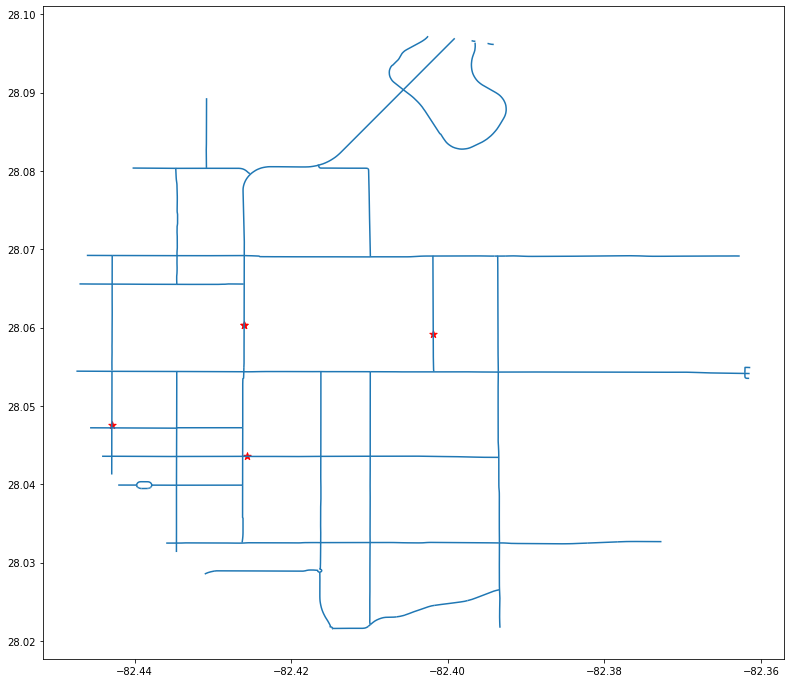

In [36]:
output_points = sample_roads(output, n=5, isLine=False)
ax = output.plot(figsize=(14, 12))
output_points.plot(marker='*', color='red', markersize=60, ax=ax)

In [37]:
intersection_2 = lines.intersection(sample_civic_df.geometry[1])
output_2 = gpd.GeoDataFrame({'geometry':intersection_2})

In [38]:
length_arr = []
for i in range(len(output_2)):
  length_i = output_2['geometry'][i].length
  length_arr.append(length_i)

output_2['LENGTH'] = length_arr

#### Sampling 3 lines within INTERSECTION of HIL road network and 2nd sampled civic center region

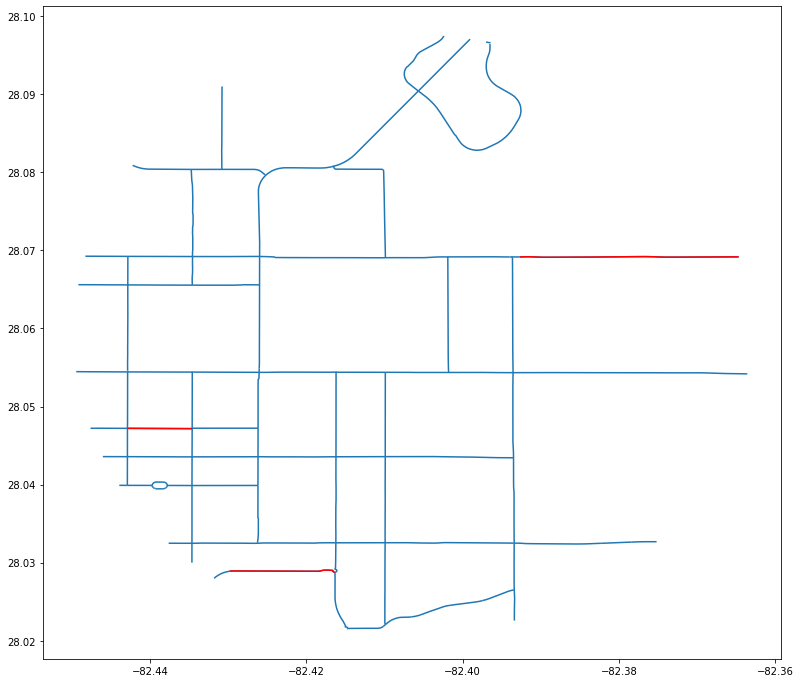

In [39]:
output_lines_2 = sample_roads(output_2, n=3, isLine=True)
ax = output_2.plot(figsize=(14, 12))
output_lines_2.plot(marker='*', color='red', markersize=60, ax=ax)

## Converting GeoSeries to GeoPandas Dataframe Test

In [40]:
envgdf = gpd.GeoDataFrame(gpd.GeoSeries(output_lines_2))

In [41]:
envgdf = envgdf.rename(columns={0:'geometry'}).set_geometry('geometry')

In [42]:
envgdf

,geometry
0,"LINESTRING (-82.44290 28.04721, -82.43462 28.0..."
1,"LINESTRING (-82.42984 28.02891, -82.42955 28.0..."
2,"LINESTRING (-82.39267 28.06915, -82.39256 28.0..."
